# Importing modules

In [ ]:
!pip install tabnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import re

from pandas.io.formats.style_render import DataFrame
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from math import ceil
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
import pickle
import os
import shutil
import tensorflow as tf
import tensorflow_datasets as tfds
import tabnet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the dataset

In [ ]:
!cp /content/drive/Shareddrives/DM_Project/dataset/users_clustering.csv /content/
!cp /content/drive/Shareddrives/DM_Project/dataset/users_extended_clean.csv /content/

In [ ]:
users = pd.read_csv("users_clustering.csv")

In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      11508 non-null  int64  
 1   name                    11508 non-null  object 
 2   lang                    11508 non-null  object 
 3   bot                     11508 non-null  int64  
 4   created_at              11508 non-null  object 
 5   statuses_count          11508 non-null  int64  
 6   reply_count_total       11508 non-null  float64
 7   favorite_count_total    11508 non-null  int64  
 8   num_hashtags_total      11508 non-null  int64  
 9   retweet_count_avg       11508 non-null  float64
 10  reply_count_avg         11508 non-null  float64
 11  favorite_count_avg      11508 non-null  float64
 12  num_hashtags_avg        11508 non-null  float64
 13  num_urls_avg            11508 non-null  float64
 14  num_mentions_avg        11508 non-null

# Build the dataset

In [ ]:
users.drop(columns=['name', 'lang', 'created_at', "id"], axis=1, inplace=True)
label = users.pop('bot')

# Train TabNet


In [ ]:
data_set_dict = {
    "features": users.to_numpy(),
    "label": label.to_numpy()
}

print(data_set_dict["features"].shape, data_set_dict["label"].shape)

(11508, 27) (11508,)


In [ ]:
train_set = tf.data.Dataset.from_tensor_slices(data_set_dict)

train_size = int(len(train_set)*0.8)
BATCH_SIZE = 128


def transform(ds):
    features = tf.unstack(ds['features'])
    labels = ds['label']

    x = dict(zip(col_names, features))
    y = tf.one_hot(labels, 2)
    return x, y


col_names = users.columns

ds_train = train_set.take(train_size)
ds_train = ds_train.map(transform)
ds_train = ds_train.batch(BATCH_SIZE)

ds_test = train_set.skip(train_size)
ds_test = ds_test.map(transform)
ds_test = ds_test.batch(BATCH_SIZE)



feature_columns = []
for col_name in col_names:
    feature_columns.append(tf.feature_column.numeric_column(col_name))


In [ ]:
model = tabnet.TabNetClassifier(feature_columns, num_classes=2,
                                feature_dim=8, output_dim=4,
                                num_decision_steps=4, relaxation_factor=1.0,
                                sparsity_coefficient=1e-5, batch_momentum=0.98,
                                virtual_batch_size=None, norm_type='group',
                                num_groups=1)

lr = tf.keras.optimizers.schedules.ExponentialDecay(0.01, decay_steps=100, decay_rate=0.9, staircase=False)
optimizer = tf.keras.optimizers.Adam(lr)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(ds_train, epochs=100, validation_data=ds_test, verbose=2)

model.summary()

print()
if os.path.exists('logs/'):
    shutil.rmtree('logs/')

""" Save the images of the feature masks """
# Force eager execution mode to generate the masks
x, y = next(iter(ds_train))
_ = model(x)

writer = tf.summary.create_file_writer("logs/")
with writer.as_default():
    for i, mask in enumerate(model.tabnet.feature_selection_masks):
        print("Saving mask {} of shape {}".format(i + 1, mask.shape))
        tf.summary.image('mask_at_iter_{}'.format(i + 1), step=0, data=mask, max_outputs=1)
        writer.flush()

    agg_mask = model.tabnet.aggregate_feature_selection_mask
    print("Saving aggregate mask of shape", agg_mask.shape)
    tf.summary.image("Aggregate Mask", step=0, data=agg_mask, max_outputs=1)
    writer.flush()

writer.close()

[TabNet]: 4 features will be used for decision steps.
Epoch 1/100
72/72 - 16s - loss: 0.5047 - accuracy: 0.7498 - val_loss: 0.4435 - val_accuracy: 0.8167 - 16s/epoch - 224ms/step
Epoch 2/100
72/72 - 2s - loss: 0.4199 - accuracy: 0.8143 - val_loss: 0.4084 - val_accuracy: 0.8119 - 2s/epoch - 28ms/step
Epoch 3/100
72/72 - 2s - loss: 0.4035 - accuracy: 0.8213 - val_loss: 0.4430 - val_accuracy: 0.7719 - 2s/epoch - 28ms/step
Epoch 4/100
72/72 - 2s - loss: 0.5302 - accuracy: 0.7420 - val_loss: 0.6408 - val_accuracy: 0.6368 - 2s/epoch - 28ms/step
Epoch 5/100
72/72 - 2s - loss: 0.5570 - accuracy: 0.6872 - val_loss: 0.3874 - val_accuracy: 0.8293 - 2s/epoch - 27ms/step
Epoch 6/100
72/72 - 2s - loss: 0.3922 - accuracy: 0.8239 - val_loss: 0.3915 - val_accuracy: 0.8510 - 2s/epoch - 28ms/step
Epoch 7/100
72/72 - 2s - loss: 0.4216 - accuracy: 0.8170 - val_loss: 0.4859 - val_accuracy: 0.7680 - 2s/epoch - 28ms/step
Epoch 8/100
72/72 - 2s - loss: 0.4795 - accuracy: 0.7862 - val_loss: 0.4140 - val_accurac

# Visualize attention masks

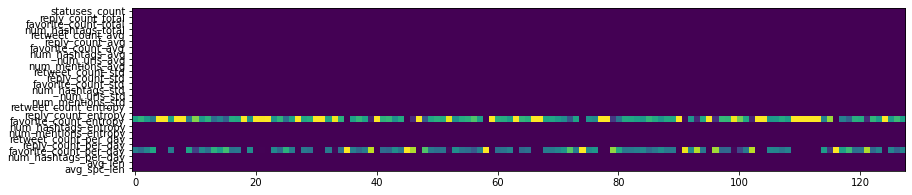

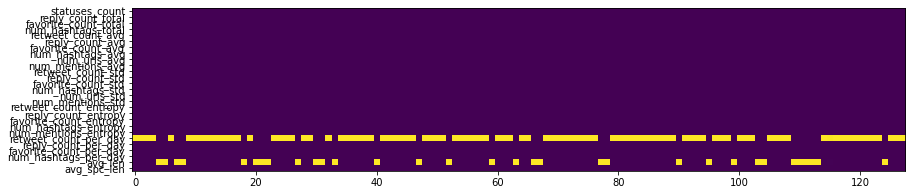

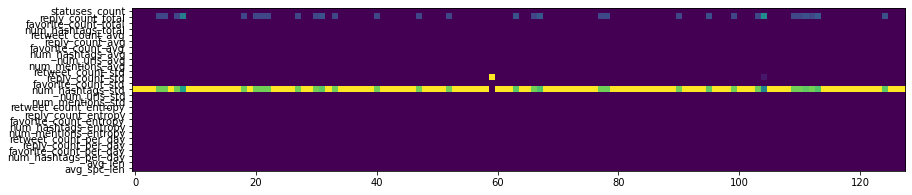

In [ ]:
for mask in model.tabnet.feature_selection_masks:
  #print(mask[0].numpy())
  d1 = mask.shape[1]
  d2 = mask.shape[2]
  plt.figure(figsize = (d1, d2//7))

  mask = mask[0].numpy().reshape((d1, d2))
  mask = mask.swapaxes(0,1)

  plt.imshow(mask)
  # plt.xticks(list(users.columns))
  plt.yticks([x for x in range(d2)], list(users.columns))
  plt.show()

(27, 128)


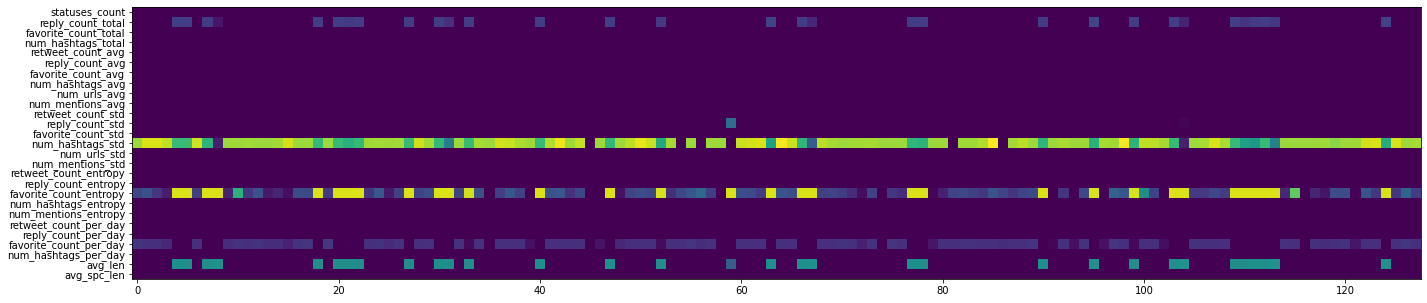

In [ ]:
mask = model.tabnet.aggregate_feature_selection_mask
d1 = mask.shape[1]
d2 = mask.shape[2]
plt.figure(figsize = (d2, d1//25))

mask = mask[0].numpy().reshape((d1, d2))
mask = mask.swapaxes(0,1)
print(mask.shape)

plt.imshow(mask)
plt.yticks([x for x in range(d2)], list(users.columns))
plt.show()

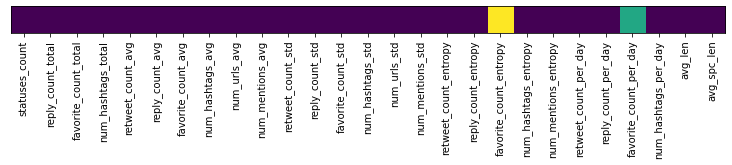

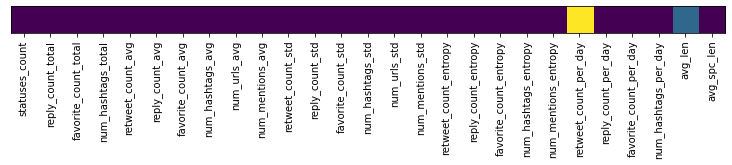

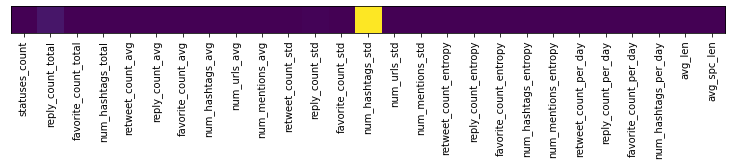

In [ ]:
avg_mask = np.zeros(model.tabnet.feature_selection_masks[0].shape)
for mask in model.tabnet.feature_selection_masks:
  avg_mask+=mask
  #print(mask[0].numpy())
  d1 = mask.shape[1]
  d2 = mask.shape[2]
  mask = mask[0]
  avg = tf.reduce_mean(mask, axis=0)
  avg = avg.numpy().swapaxes(0,1)
  
  plt.figure(figsize = (d1/10, d2))
  plt.imshow(avg)
  plt.xticks([x for x in range(d2)], list(users.columns), rotation=90)
  plt.yticks([])
  plt.show()
  
  # plt.figure(figsize = (d1, d2))
  # plt.imshow(mask[0].numpy().reshape((d1, d2)))
  # print(d2)
  # # plt.xticks(list(us, rotation=90ers.columns))
  # plt.show()
avg/=len(model.tabnet.feature_selection_masks)

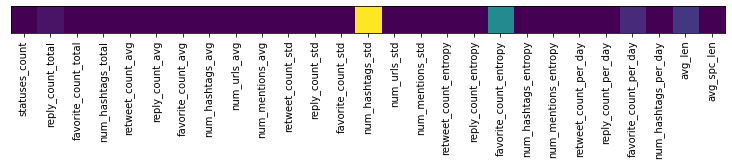

In [ ]:
mask = model.tabnet.aggregate_feature_selection_mask
d1 = mask.shape[1]
d2 = mask.shape[2]
plt.figure(figsize = (d1/10, d2))

mask = mask[0]
mask = tf.reduce_mean(mask, axis=0)

mask = mask.numpy()

mask = mask.swapaxes(0,1)

plt.imshow(mask)
plt.xticks([x for x in range(d2)], list(users.columns), rotation=90)
plt.yticks([])
plt.show()

# Measure performances

In [ ]:
train_pred = model.predict(ds_train)
test_pred = model.predict(ds_test)

18/18 [==============================] - 0s 21ms/step


In [ ]:
train_pred = np.argmax(train_pred, axis=1)
test_pred = np.argmax(test_pred, axis=1)

In [ ]:
train_label = []
for x in ds_train.unbatch():
  train_label.append(np.argmax(x[1].numpy()))
train_label = np.array(train_label)

[1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 

In [ ]:
test_label = []
for x in ds_test.unbatch():
  test_label.append(np.argmax(x[1].numpy()))
test_label = np.array(test_label)

In [ ]:
def print_metrics(train_label, train_pred, test_label, test_pred):

  print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred))
  print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred))

  print('Precision train set ', metrics.precision_score(train_label, train_pred))
  print('Precision test set ', metrics.precision_score(test_label, test_pred))

  print('Recall train set ', metrics.recall_score(train_label, train_pred))
  print('Recall test set ', metrics.recall_score(test_label, test_pred))

  print('F1 score train set ', metrics.f1_score(train_label, train_pred))
  print('F1 score train set ', metrics.f1_score(test_label, test_pred))

  print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred)[3])
  print('Support test set ', metrics.precision_recall_fscore_support(test_label, test_pred)[3])

In [ ]:
print_metrics(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.8777970888550946
Accuracy test set  0.891398783666377
Precision train set  0.8237620357634112
Precision test set  0.8406708595387841
Recall train set  0.9795542833776324
Recall test set  0.9820408163265306
F1 score train set  0.8949285514149622
F1 score train set  0.9058734939759036
Support train set  [4315 4891]
Support test set  [1077 1225]
